# Project Milestone Report
### Magdalena Barros, Paula Cadena, Michael Rosenbaum | CAPP 30254: Machine Learning for Public Policy 

This report describes our current progress to complete the CAPP 30254 proxy means test project. In our first two weeks, we've conducted a series of data exploration exercises to better define our training data as well as determined what our approach will be to implement and compare a set of models.

Our approach will be to use a set of .py functions to analyze the data and create 3 candidate datasets to each contribute to the cleaning process. Then, we will create a data pipeline to train and evaluate the efficacy of 4 models we have covered in class:
- Regression forests of some variety (XGBoost, standard CART)
- K-Nearest Neighbors
- Penalized multinomial logistic regressions of some variety (Elastic net, LASSO, etc.)
- A simple Neural Net

We will evaluate these models based on the model evaluation criteria we will learn in the remaining weeks of the course, likely focusing on predictive accuracy, not computation time due to the relatively smaller size of the data.

## 1 | Data Exploration

Our data exploration has focued on understanding the underlying dataset. The data comes from a [2017 ILO survey administered](https://webapps.ilo.org/surveyLib/index.php/catalog/7230/related-materials) by the Intra-American Development Bank (IDB).

It is drawn from a nationally representative household survey and includes a subset of household- and individual-level variables that are cleaned by the IDB.

So far, our main focus has been data quality assurance and data management. We have:
- Loaded the data into Python;
- Removed extraneous variables created by the IDB such as squared age that are fully dependent on underlying data from respondents. 
- Reviewed the survey documentation to understand the data generation process.
- Evaluated data quality on missingness, item nonresponse, and unit of analysis.
- Created a development and training data split so that our internal analysis of missing

### Results

Three variables have a significant amount of missing values:

1. Type of house (`v2a1`): Families with fully paid houses, living in precarious situations, and others have missing values. The choice is to deal with this by replacing NaN values with zero in cases where houses are fully paid and leaving the missing values in all others.

1. Number of tablets owned (`v18q1`): All `NaN` values are the cases in which families said that they don't own a tablet in question `v18q`. The decision was to replace `NaN` with zeros, referencing that zero tablets are owned by the household.
    
1. Grades behind (`rez_esc`): This variable calculates how many years behind a person is in education based on age. It has so many missing values because it only references cases where the family member is between 5 and 17 years old. All others are considered `NaN`, and the decision was not to make any changes.


In [13]:
# External packages
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE

# Internal functions
sys.path.append(os.path.dirname(os.path.abspath(''))) # From https://stackoverflow.com/questions/9856683/using-pythons-os-path-how-do-i-go-up-one-directory
from model.clean import load_data

In [15]:
cr_df = load_data("train.csv")
cr_df.isnull().sum()[cr_df.isnull().sum() != 0]

v2a1        6860
v18q1       7342
rez_esc     7928
meaneduc       5
dtype: int64

### Outcome Distribution

The outcome distribution is also heavily skewed. Even the outcome is subset to the household-level nearly 70% of the observations are in the highest income category.

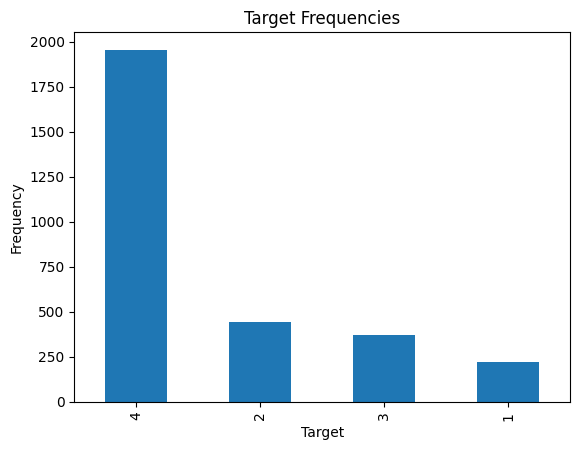

In [16]:
# Filter the DataFrame where 'parentesco1' equals 1
parentesco1_eq_1 = cr_df[cr_df['parentesco1'] == 1]
parentesco2_eq_1 = cr_df[cr_df['parentesco2'] == 1]
parentesco3_eq_1 = cr_df[cr_df['parentesco3'] == 1]

# Concatenate the filtered DataFrames to create a subset of unique 'idhogar' values
subset_df = pd.concat([parentesco1_eq_1, parentesco2_eq_1, parentesco3_eq_1]).drop_duplicates(subset='idhogar')

# Plot labels
target_counts = subset_df['Target'].value_counts()
target_counts.plot(kind='bar')

plt.xlabel('Target')
plt.ylabel('Frequency')
plt.title('Target Frequencies')
plt.show()

### Decisions

- We will oversample using synthetic data per Katherine's suggestion to respond to this in both the training and test data. We use the `imbalanced_learn.SMOTE` package to do so.
- Drop calculated variables including: `edjefe`, `edjefa`, `area2`, `r4h1`, `r4h2`, `r4h3`, `r4m1`, `r4m2`, `r4m3`, `r4t1`, `r4t2`, `overcrowding`, `tamhog`, `tamviv`, `male`, `hogar_total`, `dependency`, `meaneduc`, `SQBescolari`, `SQBage`, `SQBhogar_total`, `SQBedjefe`, `SQBhogar_nin`, `SQBovercrowding`, `SQBdependency`, `SQBmeaned`, `agesq`, `techozinc`,
`techoentrepiso`,
`techocane`,
`techootro`.
- Retain `hhsize` and drop `tamhog`, `r4t3`, `tamviv` as `hhsize` is calculated by the survey software based on the household roster, whereas each other is not aligned with the counts of household compositions variables (age, sex, etc.) 
- Collapse individual-level categorical variables that have percentages less than 5%:
    - `estadocivil` is collapsed into 4 categories from 7.
    - `instlevel` is collapsed into 6 categories from 10.
    - `parentesco` is collapsed into 4 categories from 12.
- Collapse household-level categorical variables that have percentages less than 5% including durable assets: `piso`, `pared`, `techo`, `sanitario`, `elimbasu`, `tipovivi` (forthcoming)

### Output

This has lead us to a foundational dataset with only data from the underlying population (and not IDB analysts) remaining, only single indicator variables for discrete variables (i.e., only keeping male from male and female), and only categories with 5% of more responses.

We will create two sets of training data from this to train our chosen models on. These training sets aim to compare different approaches to defining the taregt population:

1. **Parsimonious household-level dataset**: The smallest and simplest dataset we can create of household-level data. This assumes that the survey data contains a lot of noisy variables and attempts to select candidate variables most strongly associated with underlying proxies for poverty status: liquid and illiquid wealth, income, income potential, and resilience.
1. **Complicated household-level dataset**: Keeping the data at the household-level, we will generate features from the individual-level data and a set of more complex interactions between candidate features.

## 2 | Feature Engineering

We have started to develop features with a focus on three initial types of features:

- Comparisons between individual-level responses and household-responses (e.g., minimum education or number of students behind grade-level)
- Collapsing categories for categoricl variables with low response rates.
- Interactions between plausibly-related variables (e.g., water AND electricity)

## 3 | Future work

We have developed developed to-do list for future work to ensure that we are on track for completing the fina work.

- \[May 5\] Create candidate datasets
- \[May 10\] Model selection
- \[May 17\] Model validation
- \[May 19\] Report completion